In [1]:
from AudioDataset import AudioDataset
from torch.utils.data import DataLoader
from model_helper import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using CUDA device for GPU acceleration.


In [3]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]

In [4]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels=80, n_classes=12, d_model=128, nhead=4, num_layers=2, dim_feedforward=256):
        super(AudioTransformer, self).__init__()
        self.input_proj = nn.Linear(n_mels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        transformer_out = self.transformer_encoder(x)
        x = transformer_out.mean(dim=1)
        out = self.classifier(x)
        return out

In [5]:
train_dataset = AudioDataset(
    csv_path="./data/train_balanced.csv",
    audio_dir="./data_raw/train/audio"
)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

In [6]:
test_dataset = AudioDataset(
    csv_path="./data/test.csv",
    audio_dir="./data_raw/train/audio"
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

Epoch 1, Loss: 1.4587
Accuracy of the network transformer with lr = 0.0005 and weight decay = 0: 46.58%
Accuracy of class "yes": 87.11%
Accuracy of class "no": 75.00%
Accuracy of class "up": 88.97%
Accuracy of class "down": 60.47%
Accuracy of class "left": 73.03%
Accuracy of class "right": 72.20%
Accuracy of class "on": 75.61%
Accuracy of class "off": 74.43%
Accuracy of class "stop": 81.93%
Accuracy of class "go": 54.58%
Accuracy of class "silence": 83.72%
Accuracy of class "unknown": 29.45%
Epoch 1, Loss: 1.3252
Accuracy of the network transformer with lr = 0.001 and weight decay = 0: 48.42%
Accuracy of class "yes": 88.67%
Accuracy of class "no": 67.86%
Accuracy of class "up": 83.46%
Accuracy of class "down": 60.08%
Accuracy of class "left": 83.90%
Accuracy of class "right": 74.13%
Accuracy of class "on": 68.70%
Accuracy of class "off": 69.85%
Accuracy of class "stop": 81.53%
Accuracy of class "go": 80.08%
Accuracy of class "silence": 69.77%
Accuracy of class "unknown": 31.65%


KeyboardInterrupt: 

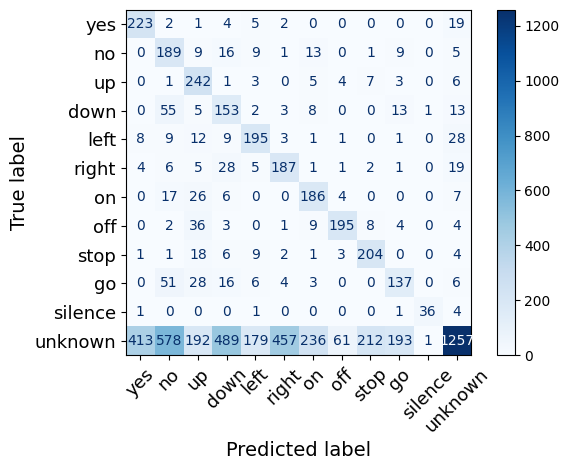

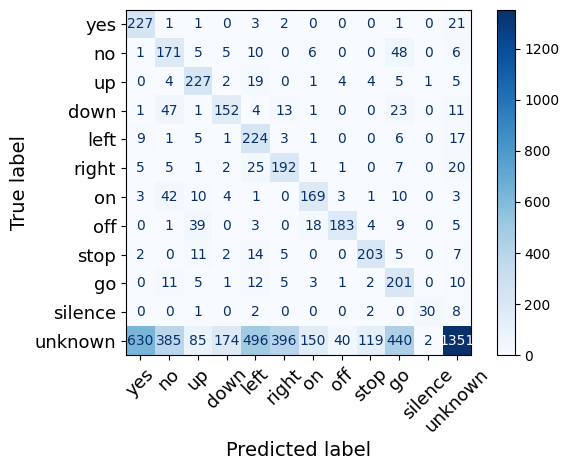

In [7]:
learning_rate_values = [0.0005, 0.001, 0.005, 0.01]
weight_decay = 0 #default value
model_name = 'transformer'
tested_parameter = 'lr'
epoch_number = 1

for lr in learning_rate_values:
    model = AudioTransformer().to(device)
    model = train_model(model, device, train_dataloader, lr=lr, weight_decay=weight_decay, model_name=model_name, epoch_number=epoch_number, save_flg = True)
    predict_model(model, device, classes, test_loader, lr=lr, weight_decay=weight_decay, model_name=model_name, tested_parameter=tested_parameter, save_flg = True)

In [ ]:
weight_decay_values = [0.0005,0.001,0.005,0.01]
lr = #tu dac najlepszy lr z poprzedniego eksperymentu
model_name = 'transformer'
tested_parameter = 'weight_decay'
epoch_number = 20

for weight_decay in weight_decay_values:
    model = AudioTransformer().to(device)
    model = train_model(model, device, train_dataloader, lr=lr, weight_decay=weight_decay, model_name=model_name, epoch_number=epoch_number, save_flg = True)
    predict_model(model, device, classes, test_loader, lr=lr, weight_decay=weight_decay, model_name=model_name, tested_parameter=tested_parameter, save_flg = True)